In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import pingouin as pg
import plotly.express as px
import seaborn as sns 
from statannot import add_stat_annotation
import os
import copy
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

d:\Tianyu\software\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
d:\Tianyu\software\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
## savgol filter ##
def SG_fil(data,window,column_name,order=2):
    df = data.copy()
    for n in column_name:
        df[n] = savgol_filter(df.loc[:,n],window,order)
    return df

def lumin2cogload(lumin):
    # coeff_left = [2.451072052, -15.47037207, 2.49154129]
    # coeff_right = [2.489320955, -13.62467234, 2.540344354]
    coeff_left = [1.326173, -4.42176, 3.016348]
    coeff_right = [1.225595, -5.16006, 3.3087083]
    cogload_adjust_left = coeff_left[0]*np.exp(coeff_left[1]*lumin) + coeff_left[2]
    cogload_adjust_right = coeff_right[0]*np.exp(coeff_right[1]*lumin) + coeff_right[2]
    return cogload_adjust_left, cogload_adjust_right

In [18]:
path = '../data/test/'

data_raw = []
data_analysis = pd.DataFrame()

PVC_1_target = np.array([0.5,0.85,0.35])
Alu_1_target = np.array([0.2,0.85,0.35])
Cas_1_target = np.array([0.8,0.85,0.35])
PVC_2_target = np.array([0.2,0.5,0.35])
Alu_2_target = np.array([0.5,0.5,0.35])
Cas_2_target = np.array([0.8,0.5,0.35])

for home, dirs, files in os.walk(path):
        for filename in files:
                t = pd.read_csv(home+"/"+filename,index_col=0)
                t = t[90:-1].reset_index()
                t[["participant_id"]] = filename[1:3]
                participant_id = filename[1:3]
                t[["condition"]] = filename[4:8]
                condition = filename[4:8]

                t['LeftPupilD'][t['LeftPupilD']<0] = np.nan
                t['RightPupilD'][t['RightPupilD']<0] = np.nan
                t[['LeftPupilD','RightPupilD']] = t[['LeftPupilD','RightPupilD']].interpolate(method='linear',axis=0,limit_direction ='both')
                t = SG_fil(t,41,['LeftPupilD','RightPupilD','Lumin'])

                (t[['cogload_adjust_left']], t[['cogload_adjust_right']]) = lumin2cogload(t[['Lumin']])
                t[['cogload_left']] = t[['LeftPupilD']].values - t[['cogload_adjust_left']].values
                t[['cogload_right']] = t[['RightPupilD']].values - t[['cogload_adjust_right']].values

                cogload_left = t["cogload_left"].mean()
                cogload_right = t["cogload_right"].mean()
                cogload = (cogload_left + cogload_right)/2
                time_all = len(t)/90

                mission_group = t.groupby('pickupName')
                mission_Alu_1 = mission_group.get_group('Pipe Aluminum 1')
                Alu_1_end = mission_Alu_1.iloc[-1][['Cube2X','Cube2Y','Cube2Z']].values
                Alu_1_time = mission_Alu_1.index[-1] - mission_Alu_1.index[0]
                mission_Alu_2 = mission_group.get_group('Pipe Aluminum 2')
                Alu_2_end = mission_Alu_2.iloc[-1][['Cube5X','Cube5Y','Cube5Z']].values
                Alu_2_time = mission_Alu_2.index[-1] - mission_Alu_2.index[0]
                mission_Cas_1 = mission_group.get_group('Pipe Cast-Iron 1')
                Cas_1_end = mission_Cas_1.iloc[-1][['Cube3X','Cube3Y','Cube3Z']].values
                Cas_1_time = mission_Cas_1.index[-1] - mission_Cas_1.index[0]
                mission_Cas_2 = mission_group.get_group('Pipe Cast-Iron 2')
                Cas_2_end = mission_Cas_2.iloc[-1][['Cube6X','Cube6Y','Cube6Z']].values
                Cas_2_time = mission_Cas_2.index[-1] - mission_Cas_2.index[0]
                mission_PVC_1 = mission_group.get_group('Pipe PVC 1')
                PVC_1_end = mission_PVC_1.iloc[-1][['Cube1X','Cube1Y','Cube1Z']].values
                PVC_1_time = mission_PVC_1.index[-1] - mission_PVC_1.index[0]
                mission_PVC_2 = mission_group.get_group('Pipe PVC 2')
                PVC_2_end = mission_PVC_2.iloc[-1][['Cube4X','Cube4Y','Cube4Z']].values
                PVC_2_time = mission_PVC_2.index[-1] - mission_PVC_2.index[0]

                collider_group = t.groupby('MeshCollider')
                collision_times = len(collider_group.groups)
                deformation_group = t.groupby('MeshDeformation')
                deformation_times = len(deformation_group.groups)

                Alu_1_R_accuracy = np.sqrt(np.power(Alu_1_end[0]-Alu_1_target[0],2) + np.power(Alu_1_end[1]-Alu_1_target[1],2))
                Alu_2_R_accuracy = np.sqrt(np.power(Alu_2_end[0]-Alu_2_target[0],2) + np.power(Alu_2_end[1]-Alu_2_target[1],2))
                PVC_1_R_accuracy = np.sqrt(np.power(PVC_1_end[0]-PVC_1_target[0],2) + np.power(PVC_1_end[1]-PVC_1_target[1],2))
                PVC_2_R_accuracy = np.sqrt(np.power(PVC_2_end[0]-PVC_2_target[0],2) + np.power(PVC_2_end[1]-PVC_2_target[1],2))
                Cas_1_R_accuracy = np.sqrt(np.power(Cas_1_end[0]-Cas_1_target[0],2) + np.power(Cas_1_end[1]-Cas_1_target[1],2))
                Cas_2_R_accuracy = np.sqrt(np.power(Cas_2_end[0]-Cas_2_target[0],2) + np.power(Cas_2_end[1]-Cas_2_target[1],2))

                Alu_1_D_accuracy = np.abs(Alu_1_end[2] - Alu_1_target[2])
                Alu_2_D_accuracy = np.abs(Alu_2_end[2] - Alu_2_target[2])
                PVC_1_D_accuracy = np.abs(PVC_1_end[2] - PVC_1_target[2])
                PVC_2_D_accuracy = np.abs(PVC_2_end[2] - PVC_2_target[2])
                Cas_1_D_accuracy = np.abs(Cas_1_end[2] - Cas_1_target[2])
                Cas_2_D_accuracy = np.abs(Cas_2_end[2] - Cas_2_target[2])

                if Alu_1_R_accuracy>0.5:
                        Alu_1_R_accuracy = data_analysis["Alu_1_R_accuracy"].max()
                if Alu_2_R_accuracy>0.5:
                        Alu_2_R_accuracy = data_analysis["Alu_2_R_accuracy"].max()
                if PVC_1_R_accuracy>0.5:
                        PVC_1_R_accuracy = data_analysis["PVC_1_R_accuracy"].max()
                if PVC_2_R_accuracy>0.5:
                        PVC_2_R_accuracy = data_analysis["PVC_2_R_accuracy"].max()
                if Cas_1_R_accuracy>0.5:
                        Cas_1_R_accuracy = data_analysis["Cas_1_R_accuracy"].max()
                if Cas_2_R_accuracy>0.5:
                        Cas_2_R_accuracy = data_analysis["Cas_2_R_accuracy"].max()

                if Alu_1_D_accuracy>0.5:
                        Alu_1_D_accuracy = data_analysis["Alu_1_D_accuracy"].max()
                if Alu_2_D_accuracy>0.5:
                        Alu_2_D_accuracy = data_analysis["Alu_2_D_accuracy"].max()
                if PVC_1_D_accuracy>0.5:
                        PVC_1_D_accuracy = data_analysis["PVC_1_D_accuracy"].max()
                if PVC_2_D_accuracy>0.5:
                        PVC_2_D_accuracy = data_analysis["PVC_2_D_accuracy"].max()
                if Cas_1_D_accuracy>0.5:
                        Cas_1_D_accuracy = data_analysis["Cas_1_D_accuracy"].max()
                if Cas_2_D_accuracy>0.5:
                        Cas_2_D_accuracy = data_analysis["Cas_2_D_accuracy"].max()

                total_R_accuracy = Alu_1_R_accuracy + Alu_2_R_accuracy + PVC_1_R_accuracy + PVC_2_R_accuracy + Cas_1_R_accuracy + Cas_2_R_accuracy
                total_D_accuracy = Alu_1_D_accuracy + Alu_2_D_accuracy + PVC_1_D_accuracy + PVC_2_D_accuracy + Cas_1_D_accuracy + Cas_2_D_accuracy


                data_analysis = data_analysis.append(pd.DataFrame([[condition,participant_id,time_all,collision_times,deformation_times,total_R_accuracy,total_D_accuracy,
                                                                Alu_1_time,Alu_2_time,Cas_1_time,Cas_2_time,PVC_1_time,PVC_2_time,
                                                                Alu_1_R_accuracy,Alu_2_R_accuracy,PVC_1_R_accuracy,PVC_2_R_accuracy,Cas_1_R_accuracy,Cas_2_R_accuracy,
                                                                Alu_1_D_accuracy,Alu_2_D_accuracy,PVC_1_D_accuracy,PVC_2_D_accuracy,Cas_1_D_accuracy,Cas_2_D_accuracy,
                                                                ]],
                                                columns=["condition","participant_id","time_all","collision_times","deformation_times","total_R_accuracy","total_D_accuracy",
                                                        "Alu_1_time","Alu_2_time","Cas_1_time","Cas_2_time","PVC_1_time","PVC_2_time",
                                                        "Alu_1_R_accuracy","Alu_2_R_accuracy","PVC_1_R_accuracy","PVC_2_R_accuracy","Cas_1_R_accuracy","Cas_2_R_accuracy",
                                                        "Alu_1_D_accuracy","Alu_2_D_accuracy","PVC_1_D_accuracy","PVC_2_D_accuracy","Cas_1_D_accuracy","Cas_2_D_accuracy",
                                                        ]),
                                                ignore_index=True)

data_analysis[['collision_times','deformation_times']] = data_analysis[['collision_times','deformation_times']].astype(float)

C:\Users\Du-Lab\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3062: DtypeWarning: Columns (75) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-18-33c4c5dd7fe1>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['LeftPupilD'][t['LeftPupilD']<0] = np.nan
<ipython-input-18-33c4c5dd7fe1>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['RightPupilD'][t['RightPupilD']<0] = np.nan
<ipython-input-18-33c4c5dd7fe1>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [19]:
data_analysis

,condition,participant_id,time_all,collision_times,deformation_times,total_R_accuracy,total_D_accuracy,Alu_1_time,Alu_2_time,Cas_1_time,...,PVC_1_R_accuracy,PVC_2_R_accuracy,Cas_1_R_accuracy,Cas_2_R_accuracy,Alu_1_D_accuracy,Alu_2_D_accuracy,PVC_1_D_accuracy,PVC_2_D_accuracy,Cas_1_D_accuracy,Cas_2_D_accuracy
0,Cont,01,118.733333,6.0,3.0,0.109424,0.347274,627,2411,1312,...,0.009306,0.032516,0.007547,0.028598,0.022919,0.086384,0.064005,0.009044,0.096608,0.068314
1,Hapt,01,145.077778,0.0,0.0,0.064553,0.131511,1189,1781,1754,...,0.009770,0.010086,0.011324,0.011477,0.013230,0.012197,0.078089,0.011504,0.008892,0.007599
2,Mult,01,133.255556,0.0,0.0,0.064181,0.064120,961,1670,1524,...,0.009958,0.009844,0.012520,0.011388,0.014018,0.009724,0.004654,0.013845,0.001587,0.020292
3,Visu,01,103.011111,4.0,1.0,0.109672,0.319550,1087,1135,1844,...,0.011383,0.013158,0.044340,0.012942,0.048808,0.058390,0.059841,0.070566,0.052965,0.028980
4,Cont,02,132.611111,4.0,5.0,0.239115,0.247424,885,1298,1282,...,0.027436,0.017729,0.070777,0.024512,0.009159,0.047009,0.035219,0.009958,0.040109,0.105969
5,Hapt,02,155.077778,0.0,0.0,0.081660,0.047696,874,1785,1611,...,0.013381,0.015685,0.018797,0.005815,0.006858,0.003929,0.002869,0.000721,0.018559,0.014759
6,Mult,02,102.600000,0.0,1.0,0.093640,0.047925,596,2234,1288,...,0.012399,0.014835,0.012514,0.020905,0.002138,0.000727,0.001002,0.006951,0.012276,0.024831
7,Visu,02,130.877778,3.0,1.0,0.272235,0.210840,2114,1136,1799,...,0.014208,0.040933,0.061051,0.071598,0.075258,0.025100,0.014888,0.054590,0.005019,0.035985
8,Cont,03,150.022222,5.0,4.0,0.172476,0.405235,1275,1288,3277,...,0.044457,0.025877,0.046497,0.017616,0.061023,0.051206,0.024741,0.048464,0.142589,0.077211
9,Hapt,03,175.822222,1.0,0.0,0.079770,0.051980,1073,3016,1934,...,0.015049,0.014249,0.015029,0.013814,0.002229,0.022549,0.004556,0.000312,0.006281,0.016053


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  pratt
Cont v.s. Visu: Wilcoxon test (paired samples), P_val=6.250e-01 stat=5.000e+00
Using zero_method  pratt
Visu v.s. Hapt: Wilcoxon test (paired samples), P_val=6.250e-02 stat=0.000e+00
Using zero_method  pratt
Hapt v.s. Mult: Wilcoxon test (paired samples), P_val=1.573e-01 stat=0.000e+00
Using zero_method  pratt
Cont v.s. Hapt: Wilcoxon test (paired samples), P_val=6.250e-02 stat=0.000e+00
Using zero_method  pratt
Visu v.s. Mult: Wilcoxon test (paired samples), P_val=6.250e-02 stat=0.000e+00


d:\Tianyu\software\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
d:\Tianyu\software\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Using zero_method  pratt
Cont v.s. Mult: Wilcoxon test (paired samples), P_val=6.250e-02 stat=0.000e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  pratt
Cont v.s. Visu: Wilcoxon test (paired samples), P_val=6.250e-01 stat=4.500e+00
Using zero_method  pratt
Visu v.s. Hapt: Wilcoxon test (paired samples), P_val=5.561e-02 stat=0.000e+00
Using zero_method  pratt
Hapt v.s. Mult: Wilcoxon test (paired samples), P_val=3.173e-01 stat=0.000e+00
Using zero_method  pratt
Cont v.s. Hapt: Wilcoxon test (paired samples), P_val=6.250e-02 stat=0.000e+00


d:\Tianyu\software\anaconda3\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
d:\Tianyu\software\anaconda3\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Using zero_method  pratt
Visu v.s. Mult: Wilcoxon test (paired samples), P_val=8.969e-02 stat=0.000e+00
Using zero_method  pratt
Cont v.s. Mult: Wilcoxon test (paired samples), P_val=6.250e-02 stat=0.000e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  pratt
Cont v.s. Visu: Wilcoxon test (paired samples), P_val=1.000e+00 stat=7.000e+00
Using zero_method  pratt
Visu v.s. Hapt: Wilcoxon test (paired samples), P_val=1.250e-01 stat=1.000e+00
Using zero_method  pratt
Hapt v.s. Mult: Wilcoxon test (paired samples), P_val=8.125e-01 stat=6.000e+00
Using zero_method  pratt
Cont v.s. Hapt: Wilcoxon test (paired samples), P_val=6.250e-02 stat=0.000e+00
Using zero_method  pratt
Visu v.s. Mult: Wilcoxon test (paired samples), P_val=1.250e-01 stat=1.000e+00
Using zero_method  pratt
Cont v.s. Mult: Wilcoxon test (paired samples), P_val=6.250e-02 stat=0.000e+00
p-va

Text(1715.6521739130435, 0.5, 'Total Depth Error')

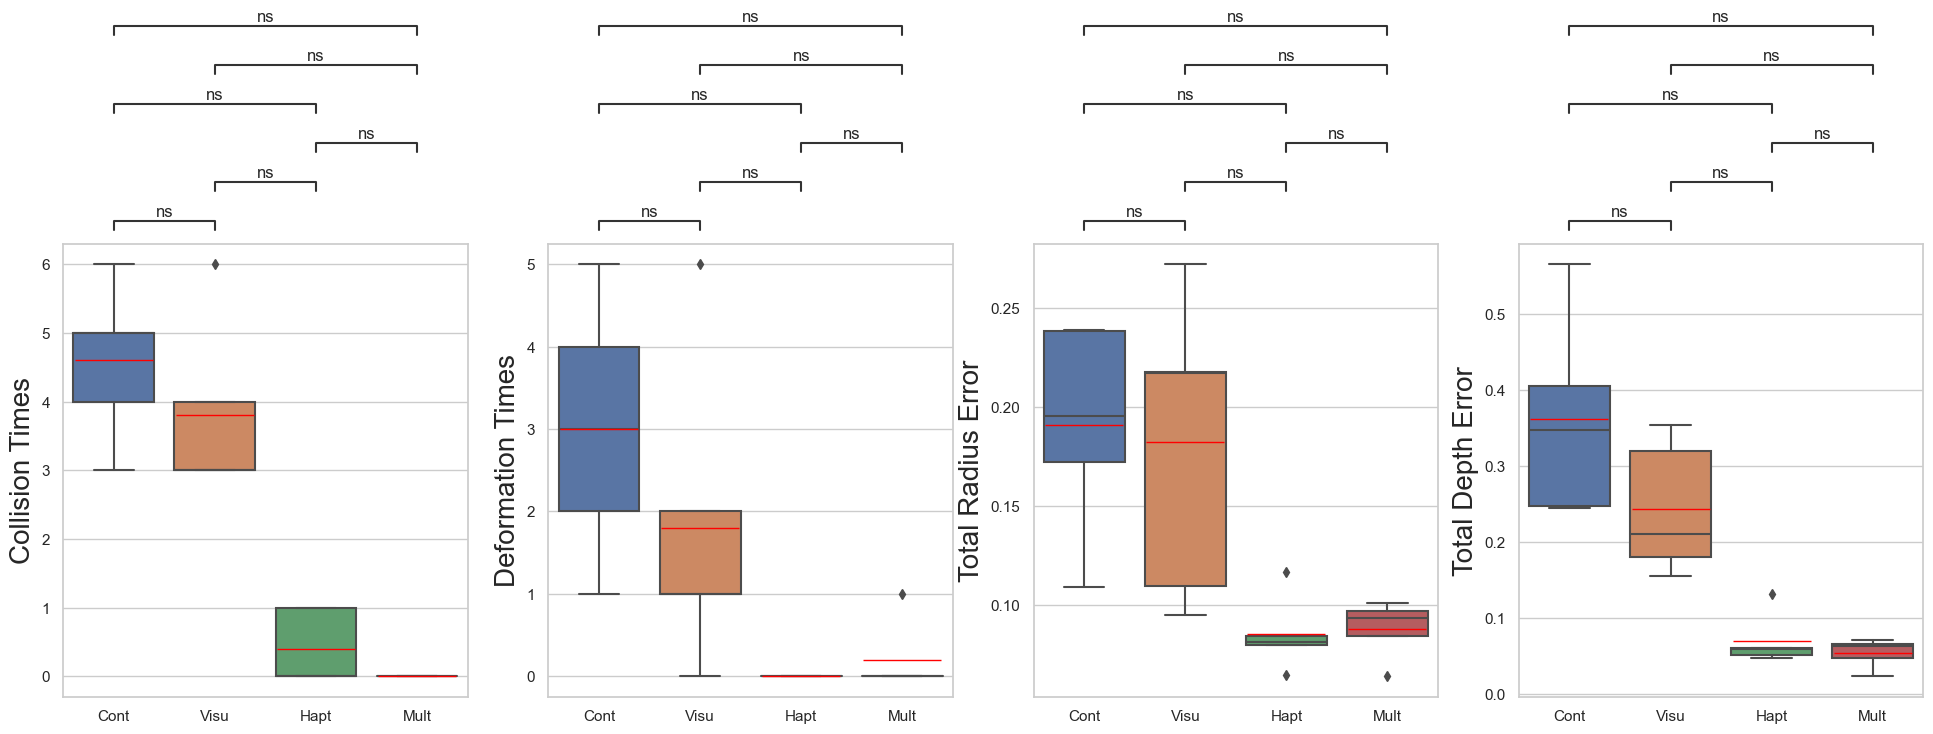

In [20]:
### pair analysis visualization 
sns.set(style = 'whitegrid')
x = 'condition'
y_list = ["collision_times","deformation_times","total_R_accuracy","total_D_accuracy"]; y_name = ['Collision Times','Deformation Times','Total Radius Error','Total Depth Error']
order = ["Cont","Visu","Hapt","Mult"]
method = 'Wilcoxon'
# method = 'Kruskal'
data = data_analysis
box_pairs=[
         (order[0], order[1]),
         (order[0], order[2]),
         (order[0], order[3]),
         (order[1], order[2]),
         (order[1], order[3]),
         (order[2], order[3]),
            ]

average_line_length = "56" #76

fig, axes = plt.subplots(1,4, figsize=(24,6), dpi=100)
y = y_list[0]
axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
# axes[0] = sns.violinplot(ax = axes[0], data=data, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
axes[0].set_xlabel('', fontsize = 20)
axes[0].set_ylabel(y_name[0], fontsize = 20)


y = y_list[1]
axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
axes[1].set_xlabel('', fontsize = 20)
axes[1].set_ylabel(y_name[1], fontsize = 20)

y = y_list[2]
axes[2] = sns.boxplot(ax = axes[2],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[2], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'less'}
                                 )
axes[2].set_xlabel('', fontsize = 20)
axes[2].set_ylabel(y_name[2], fontsize = 20)


y = y_list[3]
axes[3] = sns.boxplot(ax = axes[3],data=data, x=x, y=y,order=order, showmeans=True, meanprops={"marker":"_","markerfacecolor":"white","markeredgecolor":"red","markersize":average_line_length})
test_results = add_stat_annotation(ax=axes[3], data=data, x=x, y=y,order=order,
                                 box_pairs=box_pairs,
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 # stats_params={'alternative': 'greater'}
                                 )
axes[3].set_xlabel('', fontsize = 20)
axes[3].set_ylabel(y_name[3], fontsize = 20)